<a href="https://colab.research.google.com/github/sujal-dhawan/Movie-Recommendation-System/blob/main/Movie_Recommendation_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Install necessary libraries
!pip install scikit-learn pandas numpy matplotlib seaborn ipywidgets fuzzywuzzy

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
from fuzzywuzzy import process

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [12]:
# Load the MovieLens dataset
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

# Load movies and ratings data
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# Preprocess data
movies['genres'] = movies['genres'].str.split('|')  # Split genres into a list
movies['genres'] = movies['genres'].fillna('').astype(str)  # Handle missing values
movies['title_normalized'] = movies['title'].str.lower().str.strip()  # Normalize titles

--2025-03-10 17:01:04--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.2’

ml-latest-small.zip 100%[===================>] 955.28K   835KB/s    in 1.1s    

2025-03-10 17:01:07 (835 KB/s) - ‘ml-latest-small.zip.2’ saved [978202/978202]

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [18]:
# Create TF-IDF matrix for genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a mapping of movie titles to indices
indices = pd.Series(movies.index, index=movies['title_normalized']).drop_duplicates()

# Function to find the closest matching title
def find_closest_title(title, titles_list):
    # Ensure titles_list is a list of strings
    if isinstance(titles_list, pd.Series):
        titles_list = titles_list.tolist()  # Convert pandas Series to list

    # Find the closest match
    closest_match, score = process.extractOne(title, titles_list)
    if score >= 80:  # Adjust threshold as needed
        return closest_match
    else:
        return None

# Function to get recommendations
def get_recommendations(title, cosine_sim=cosine_sim):
    # Normalize the input title
    title = title.lower().strip()

    # Check if the title exists in the dataset
    if title not in indices:
        # Find the closest matching title
        closest_title = find_closest_title(title, movies['title_normalized'])
        if closest_title is None:
            return "Movie not found. Please check the title and try again."
        else:
            print(f"Movie '{title}' not found. Did you mean '{closest_title}'?")
            title = closest_title

    # Get recommendations
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 recommendations
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

In [19]:
# Add a dummy director column
movies['director'] = np.random.choice(['Director A', 'Director B', 'Director C'], size=len(movies))

# Function to recommend movies by the same director
def recommend_by_director(title):
    title = title.lower().strip()
    if title not in movies['title_normalized'].values:
        return "Movie not found. Please check the title and try again."
    director = movies[movies['title_normalized'] == title]['director'].values[0]
    return movies[movies['director'] == director]['title'].head(10)

<ipython-input-20-e6eeed2ebfa7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


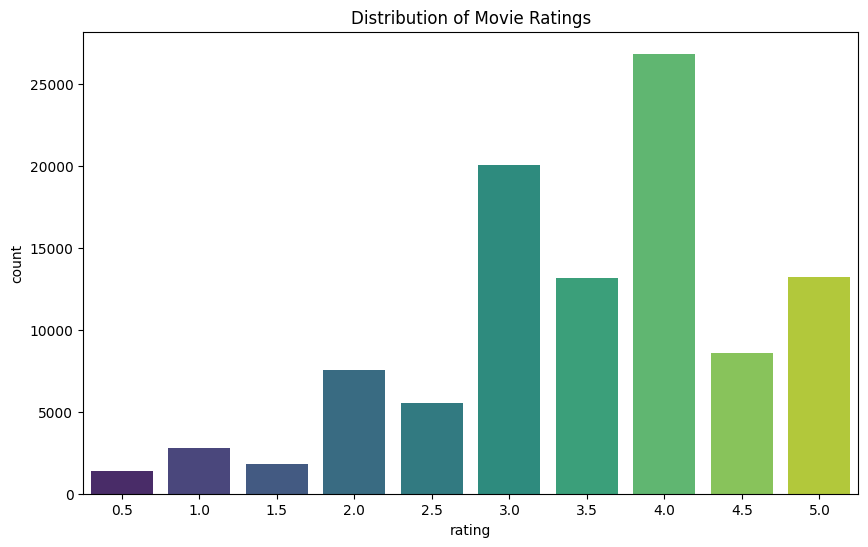

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.show()

In [21]:
# Dummy evaluation (for demonstration)
y_true = [4, 3, 5, 2, 4]
y_pred = [3.5, 3, 4.5, 2.5, 4]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.3872983346207417


In [22]:
# Create input widget for movie name
movie_input = widgets.Text(
    placeholder='Enter a movie name',
    description='Movie:',
    disabled=False
)

# Create output widget for recommendations
output = widgets.Output()

# Function to handle user input
def on_submit(sender):
    with output:
        output.clear_output()
        movie_name = movie_input.value
        print(f"Recommended Movies for '{movie_name}':")
        recommendations = get_recommendations(movie_name)
        if isinstance(recommendations, str):  # If movie not found
            print(recommendations)
        else:
            print(recommendations)
            print(f"\nMovies by the same director:")
            print(recommend_by_director(movie_name))

# Attach function to input widget
movie_input.on_submit(on_submit)

# Display widgets
display(movie_input, output)

Text(value='', description='Movie:', placeholder='Enter a movie name')

Output()

In [23]:
# Search for "The Avengers" in the dataset
avengers_movies = movies[movies['title'].str.contains('Avengers', case=False)]
print(avengers_movies)

      movieId                                              title  \
1611     2153                               Avengers, The (1998)   
6148    44020                           Ultimate Avengers (2006)   
7693    89745                               Avengers, The (2012)   
8551   115727  Crippled Avengers (Can que) (Return of the 5 D...   
8686   122892                     Avengers: Age of Ultron (2015)   
8693   122912             Avengers: Infinity War - Part I (2018)   
9153   147657                             Masked Avengers (1981)   
9488   170297                         Ultimate Avengers 2 (2006)   

                                             genres  \
1611                        ['Action', 'Adventure']   
6148  ['Action', 'Animation', 'Children', 'Sci-Fi']   
7693      ['Action', 'Adventure', 'Sci-Fi', 'IMAX']   
8551                        ['Action', 'Adventure']   
8686              ['Action', 'Adventure', 'Sci-Fi']   
8693              ['Action', 'Adventure', 'Sci-Fi']   
91